In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Reading and processing dataset

In [3]:
datasets = 'datasets/nsl-kdd'

train_file = os.path.join(datasets, 'KDDTrain+.txt')
test_file = os.path.join(datasets, 'KDDTest+.txt')

In [4]:
head_names = ['duration', 'protocol_type', 'service',
                'flag', 'src_bytes', 'dst_bytes',
                'land', 'wrong_fragment', 'urgent',
                'hot', 'num_failed_logins', 'logged_in',
                'num_compromised', 'root_shell',
                'su_attempted', 'num_root', 'num_file_creations',
                'num_shells', 'num_access_files', 'num_outbound_cmds',
                'is_host_login', 'is_guest_login', 'count', 'srv_count',
                'serror_rate', 'srv_serror_rate', 'rerror_rate',
                'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
                'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
                'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [5]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

col_names = np.array(head_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

print('> nominal columns\n\n', nominal_cols, '\n')
print('>> binary columns\n\n', binary_cols, '\n' )
print('>>> numeric columns\n\n', numeric_cols)

> nominal columns

 ['protocol_type', 'service', 'flag'] 

>> binary columns

 ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login'] 

>>> numeric columns

 ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [6]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open('datasets/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

## Generating and analyzing train and test sets

In [7]:
train_df =  pd.read_csv(train_file, names= head_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis= 1, inplace= True)

test_df =  pd.read_csv(test_file, names= head_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis= 1, inplace= True)

In [8]:
# extract the number of attack for each type (Train)
train_attack_types = train_df['attack_type'].value_counts()

# extract the number attack for each category (Train)
train_attack_cats = train_df['attack_category'].value_counts()

In [9]:
# extract the number of attack for each type (Test)
test_attack_types = test_df['attack_type'].value_counts()

# extract the number of attack for each category (Test)
test_attack_cats = test_df['attack_category'].value_counts()

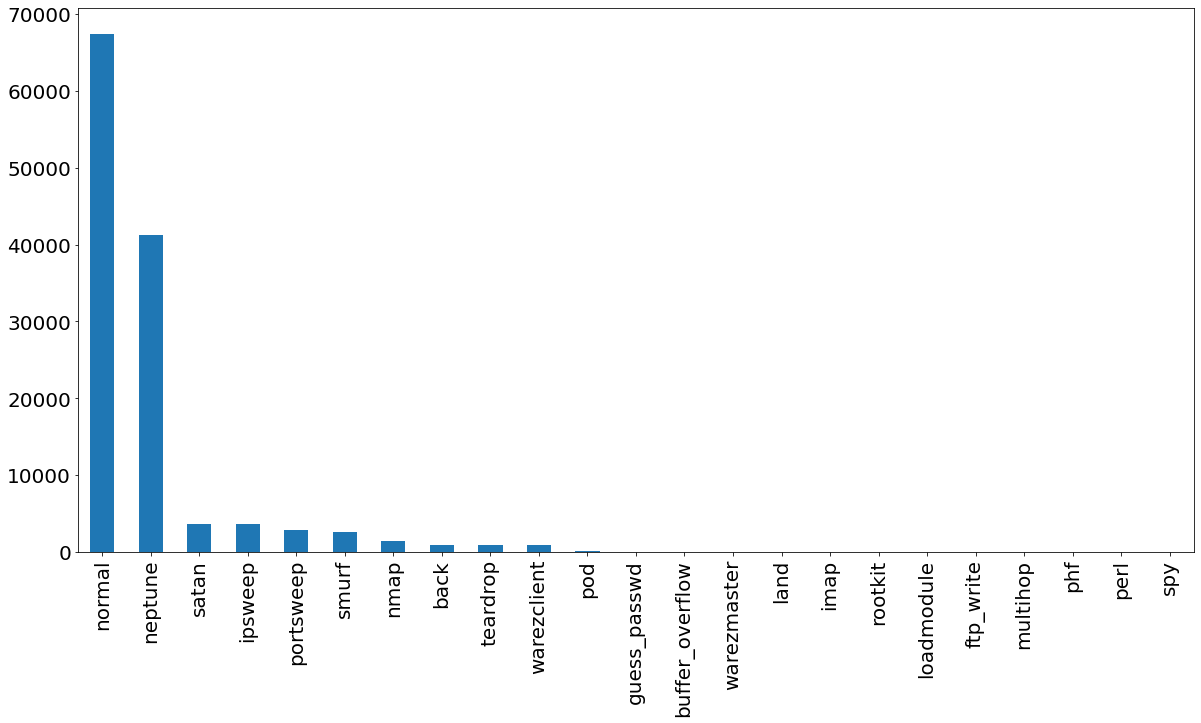

In [10]:
# plot type of attacks
train_attack_types.plot(kind= 'bar', figsize= (20, 10), fontsize= 20);

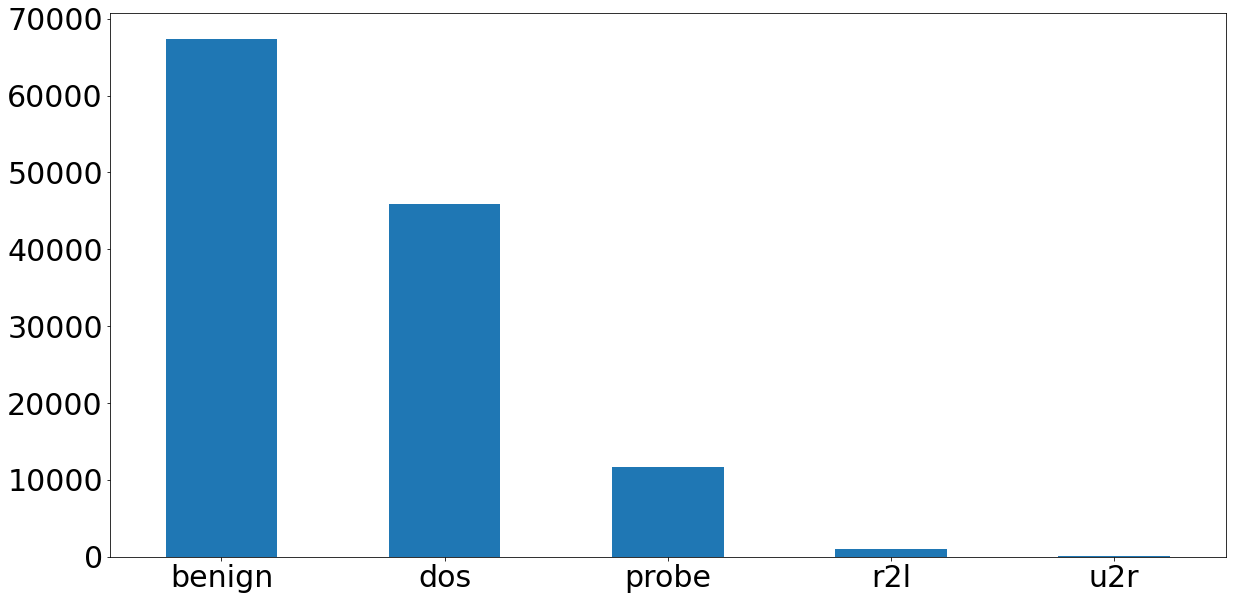

In [11]:
# plot category of attacks
train_attack_cats.plot(kind= 'bar', figsize=(20, 10), fontsize= 30);
plt.xticks(rotation = 360);

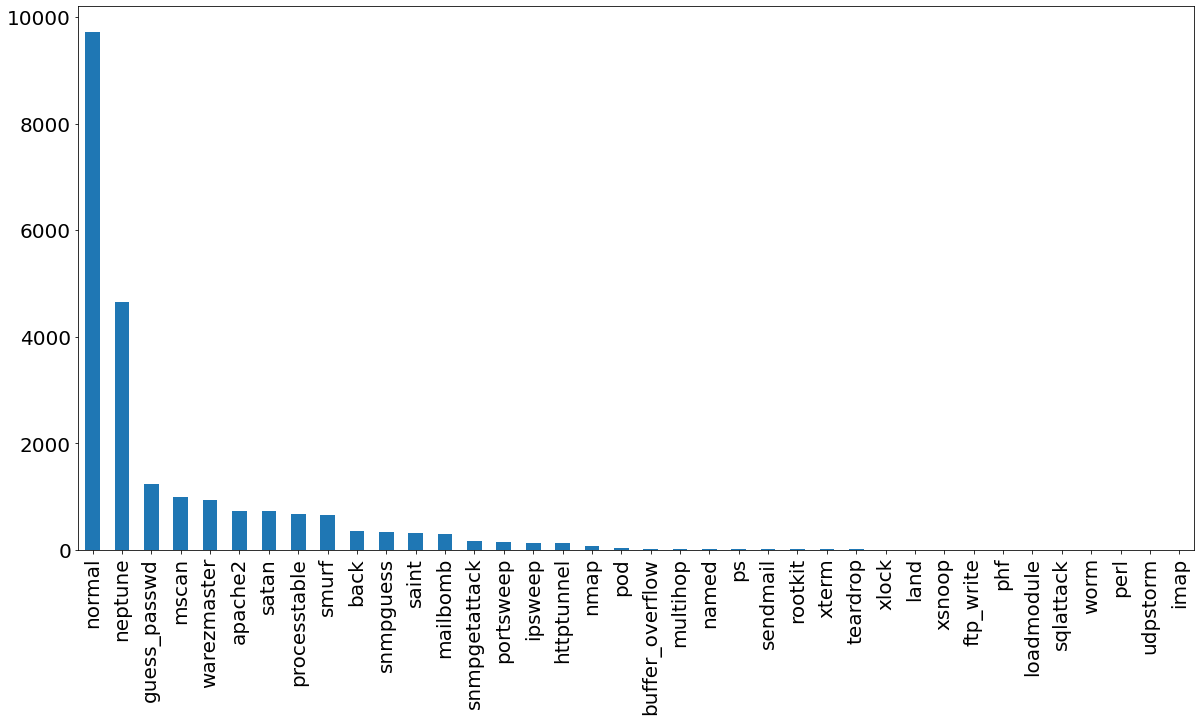

In [12]:
# plot type of attacks
test_attack_types.plot(kind= 'bar', figsize= (20, 10), fontsize= 20);

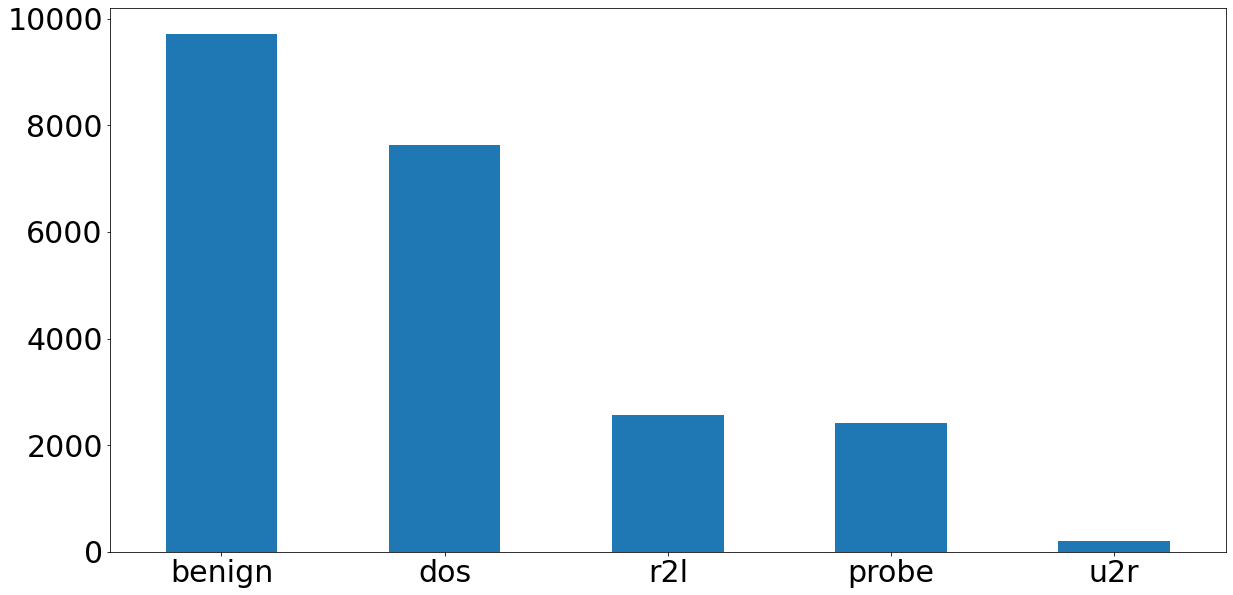

In [13]:
# plot category of attacks
test_attack_cats.plot(kind= 'bar', figsize=(20, 10), fontsize= 30);
plt.xticks(rotation = 360);

### we can notice there's some different values between train and test

## look at the binary features

In [14]:
# By definition, all of these features should have a min of 0.0 and a max of 1.0
train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.001103,0.045154,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


#### there's a problem with su_attempted column he has a 2.0 ?!

In [15]:
# let's look at grouped of all values in the column (Train)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125893
1        21
2        59
dtype: int64

In [16]:
# let's look at grouped of all values in the column (Test)
test_df.groupby(['su_attempted']).size()

su_attempted
0    22540
1        2
2        2
dtype: int64

In [17]:
# let's fix this discrepancy and assume that su_attempted = 2  ->> su_attempted= 0
train_df['su_attempted'].replace(2, 0, inplace= True)
test_df['su_attempted'].replace(2, 0, inplace= True)
train_df.groupby(['su_attempted']).size(), test_df.groupby(['su_attempted']).size()

(su_attempted
 0    125952
 1        21
 dtype: int64,
 su_attempted
 0    22542
 1        2
 dtype: int64)

## look at the numeric features

In [18]:
# we notice that the num_outbound_cmds column only takes on one value!
train_df['num_outbound_cmds'].sum()

0

#### Now, that's not a very useful feature - let's drop it from the dataset

In [19]:
train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

# Data Preparation

In [20]:
# set attack cats to separate variable (train dataset)
# set all data set as a raw without attack cats and attack type
train_y = train_df['attack_category']
train_x_row= train_df.drop(['attack_category', 'attack_type'], axis= 1)

In [21]:
# set attack cats to separate variable (test dataset)
# set all data set as a raw without attack cats and attack type
test_y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis= 1)

In [22]:
# combine two of raw data then get dummies from them to be all a numeric values
# set columns to be nominal we won't them be a messy :(
comb_df_raw = pd.concat([train_x_row, test_x_raw])
comb_df = pd.get_dummies(comb_df_raw, columns= nominal_cols, drop_first= True) 

# separate two aspects dataset after we convert it
train_x= comb_df[:len(train_x_row)]
test_x= comb_df[len(train_x_row):]

# Store dummy variable feature names
dummy_vars = list(set(train_x) - set(comb_df_raw))

In [23]:
dummy_vars

['service_iso_tsap',
 'flag_RSTO',
 'flag_S3',
 'service_gopher',
 'service_sql_net',
 'service_hostnames',
 'service_pm_dump',
 'service_http_2784',
 'service_ntp_u',
 'flag_SH',
 'flag_SF',
 'service_daytime',
 'service_imap4',
 'service_ssh',
 'service_Z39_50',
 'service_pop_3',
 'service_nntp',
 'service_harvest',
 'service_private',
 'service_eco_i',
 'service_systat',
 'service_efs',
 'service_ftp_data',
 'service_auth',
 'service_name',
 'service_supdup',
 'service_link',
 'service_other',
 'service_finger',
 'service_telnet',
 'service_klogin',
 'protocol_type_tcp',
 'service_smtp',
 'flag_S1',
 'service_pop_2',
 'service_mtp',
 'service_exec',
 'service_printer',
 'service_ldap',
 'service_ecr_i',
 'service_login',
 'service_shell',
 'service_discard',
 'service_tftp_u',
 'service_csnet_ns',
 'service_bgp',
 'service_uucp',
 'service_nnsp',
 'flag_RSTOS0',
 'service_domain_u',
 'service_urp_i',
 'service_http',
 'flag_REJ',
 'service_vmnet',
 'service_netbios_ns',
 'flag_RSTR'

In [24]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.00000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,0.08917,0.012399,0.000818,0.019218,0.276655,0.002897,0.001008,0.000389,0.594929,0.002151
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,0.28499,0.110661,0.028583,0.137292,0.447346,0.053750,0.031736,0.019719,0.490908,0.046332
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
# Example statistics for the 'duration' feature before scaling
train_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [26]:
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaled_dur = StandardScaler().fit_transform(durations)
pd.Series(standard_scaled_dur.flatten()).describe()

count    1.259730e+05
mean     3.916911e-16
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [27]:
# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaled_dur = MinMaxScaler().fit_transform(durations)
pd.Series(min_max_scaled_dur.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [28]:
# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

robust_scaled_dur= RobustScaler().fit_transform(durations)
pd.Series(robust_scaled_dur.flatten()).describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
dtype: float64

In [29]:
# Apply StandardScaler to all the numeric columns in train and test
standard_scaler = StandardScaler()

train_x[numeric_cols] = standard_scaler.fit_transform(train_x[numeric_cols])

test_x[numeric_cols] = standard_scaler.fit_transform(test_x[numeric_cols])

In [30]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,...,125973.00000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,3.916911e-16,2.559517e-16,-3.472529e-16,0.000198,9.708754e-16,3.109539e-15,-7.629865e-15,8.220883e-16,0.395736,-2.468094e-15,...,0.08917,0.012399,0.000818,0.019218,0.276655,0.002897,0.001008,0.000389,0.594929,0.002151
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014086,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.489010,1.000004e+00,...,0.28499,0.110661,0.028583,0.137292,0.447346,0.053750,0.031736,0.019719,0.490908,0.046332
min,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.102492e-01,-7.754745e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,-1.102492e-01,-7.715224e-03,-4.790326e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,1.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.636428e+01,2.350675e+02,3.257486e+02,1.000000,1.174348e+01,2.088191e+02,3.571955e+01,1.104972e+02,1.000000,3.123689e+02,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# Extract benign sets from both train and test
train_y_bin = train_y.apply(lambda x: 0 if x is 'benign' else 1)
test_y_bin = test_y.apply(lambda x: 0 if x is 'benign' else 1)

In [32]:
# import required modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [33]:
# 5-class calssification version

classifier = DecisionTreeClassifier(random_state= 17)
classifier.fit(train_x, train_y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_y, pred_y)
error = zero_one_loss(test_y, pred_y)

print(results)
print(error)

[[8318  213 1179    1    0]
 [1573 5383  680    0    0]
 [  95  831 1497    0    0]
 [1118  296 1113   47    0]
 [  25  107   68    0    0]]
0.3237668559261888


Big Error Rate !

In [34]:
# Try with KNN

clf = KNeighborsClassifier(n_neighbors= 1, n_jobs= -1)
clf.fit(train_x, train_y)

pred_y = clf.predict(test_x)

results = confusion_matrix(test_y, pred_y)
error = zero_one_loss(test_y, pred_y)

print(results)
print(error)

[[9425   56  217   11    2]
 [1503 6069   61    3    0]
 [ 728  196 1498    1    0]
 [2217    2    8  323   24]
 [ 165    0   19    7    9]]
0.23154719659332856


In [35]:
# Try with SVM
classifier = LinearSVC()
classifier.fit(train_x, train_y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_y, pred_y)
error = zero_one_loss(test_y, pred_y)

print(results)
print(error)

[[8959  134  605   11    2]
 [1693 5938    5    0    0]
 [ 739  241 1362   81    0]
 [2509    4    6   55    0]
 [ 171   17    0    3    9]]
0.2759492547906317


## Dealing with class imbalance

In [36]:
test_y.value_counts().apply(lambda x: x/float(len(test_y)))

benign    0.430758
dos       0.338715
r2l       0.114177
probe     0.107479
u2r       0.008872
Name: attack_category, dtype: float64

In [37]:
train_y.value_counts().apply(lambda x: x/float(len(train_y)))

benign    0.534583
dos       0.364578
probe     0.092528
r2l       0.007899
u2r       0.000413
Name: attack_category, dtype: float64

In [38]:
print(pd.Series(train_y).value_counts())

benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_category, dtype: int64


### we can notice whole data reduced

In [39]:
# Nowimblearnme for imblearn check out (https://imbalanced-learn.org/stable/index.html)
# first apply over sampling
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto', random_state=0)
train_x_sm, train_y_sm = sm.fit_resample(train_x, train_y)
print(pd.Series(train_y_sm).value_counts())

probe     67343
u2r       67343
r2l       67343
benign    67343
dos       67343
Name: attack_category, dtype: int64


In [40]:
# Now apply under sampling imbalence on over sampling
from imblearn.under_sampling import RandomUnderSampler

mean_class_size = int(pd.Series(train_y).value_counts().sum()/5)

ratio = {'benign': mean_class_size,
         'dos': mean_class_size,
         'probe': mean_class_size,
         'r2l': mean_class_size,
         'u2r': mean_class_size}
rus = RandomUnderSampler(sampling_strategy= ratio, random_state= 0, replacement= True)
train_x_rus, train_y_rus = rus.fit_resample(train_x_sm, train_y_sm)
print(pd.Series(train_y_rus).value_counts())

u2r       25194
r2l       25194
benign    25194
probe     25194
dos       25194
Name: attack_category, dtype: int64


Modre reduce Nice !

## Remodling our classifier

In [41]:
# Decision Tree
clf = DecisionTreeClassifier(random_state= 17)
clf.fit(train_x_rus, train_y_rus)

pred_y= clf.predict(test_x)

results = confusion_matrix(test_y, pred_y)
error = zero_one_loss(test_y, pred_y)

print(results)
print(error)

[[7437   77 2048  145    4]
 [1734 1643 4254    0    5]
 [ 315  233 1829   44    2]
 [ 825    0 1349  393    7]
 [  29    0  161   10    0]]
0.4986692689850958


In [42]:
# Try with KNN

clf = KNeighborsClassifier(n_neighbors= 1, n_jobs= -1)
clf.fit(train_x_rus, train_y_rus)

pred_y = clf.predict(test_x)

results = confusion_matrix(test_y, pred_y)
error = zero_one_loss(test_y, pred_y)

print(results)
print(error)

[[9374   57  245   24   11]
 [1495 6068   67    6    0]
 [ 705  194 1519    2    3]
 [1826    2   15  239  492]
 [  77    0   85   18   20]]
0.2361603974449965


In [43]:
# Try with SVM
classifier = LinearSVC()
classifier.fit(train_x_rus, train_y_rus)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_y, pred_y)
error = zero_one_loss(test_y, pred_y)

print(results)
print(error)

[[8903  116  680   10    2]
 [1484 5989  163    0    0]
 [ 520  173 1705   25    0]
 [2485    5   11    7   66]
 [ 173   18    2    1    6]]
0.2632185947480482


# Attempting unsupervised learning

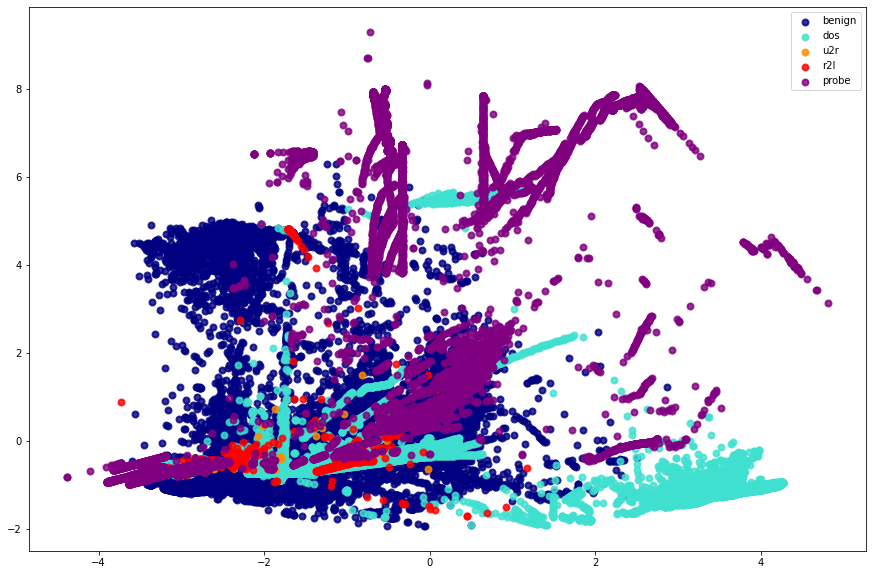

In [44]:
# First, let's visualize the dataset(only numeric cols)

from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
pca= PCA(n_components= 2)
train_x_pca_cont = pca.fit_transform(train_x[numeric_cols])

plt.figure(figsize= (15, 10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color,cat in zip(colors, category.keys()):
    plt.scatter(train_x_pca_cont[train_y == cat, 0],
                train_x_pca_cont[train_y == cat, 1],
                color= color, alpha= 0.8, lw=2, label= cat)
plt.legend(loc= 'best', shadow= False, scatterpoints= 1)
plt.show()

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(train_x)
pred_y = kmeans.predict(test_x)

print(pd.Series(pred_y).value_counts())

3    10340
2     4612
0     3722
1     2394
4     1476
dtype: int64


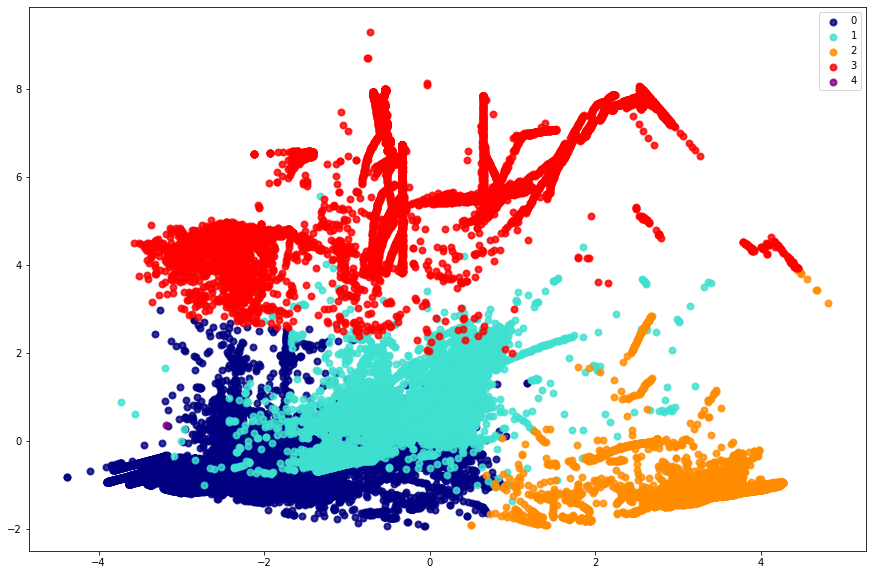

In [46]:
# Apply k-means (k=5, only using numeric cols) + PCA + plot
from sklearn.cluster import KMeans
# Fit the training data to a k-means clustering estimator model
kmeans= KMeans(n_clusters= 5, random_state= 17)
kmeans.fit(train_x[numeric_cols])

# Retrieve the labels assigned to each training sample
kmeans_y = kmeans.labels_

# plot in 2d with train_pca_cont
plt.figure(figsize= (15, 10))
color = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, range(5)):
    plt.scatter(train_x_pca_cont[kmeans_y == cat, 0],
                train_x_pca_cont[kmeans_y == cat, 1],
                color= color, alpha= .8, lw= 2, label= cat)
plt.legend(loc= 'best', shadow= False, scatterpoints= 1)
plt.show()

In [47]:
# look at number of features 
print('Total number of features : {}'.format(len(train_x.columns)))
# and number fo continuous features
print('Total number of continuous features: {}'.format(len(train_x[numeric_cols].columns)))

Total number of features : 118
Total number of continuous features: 31


### Evaluating 
Evaluating results of clustering is not as
simple as just comparing expected and predicted labels.

#### Method
To evaluate our model, we compute how many benign samples are grouped into the
same cluster, and how many samples of other classes are grouped into that cluster

**Specifically**, we compute two metrics, the **completeness score** and the **homogeneity score**.

A cluster is **complete** (has completeness score 1) if all data points belonging to the same class (i.e., with the same class label) are clustered together.
On the other hand, 
a cluster is **homogeneous** (has homogeneity score 1) if all data points that are clustered together belong to the same class.

The **V-measure**, defined to be the harmonic
mean of homogeneity and completeness, provides a convenient single metric
for evaluation:

In [48]:
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

print('Completeness: {}'.format(completeness_score(test_y, pred_y)))
print('Homogeneity: {}'.format(homogeneity_score(test_y, pred_y)))
print('V-measure: {}'.format(v_measure_score(test_y, pred_y)))

Completeness: 0.29640891810564324
Homogeneity: 0.32872199871115093
V-measure: 0.31173032519859295


A V-measure score of 0.30 is a really bad result. It looks like the data in its current state is not suitable for unsupervised classification.

# Feature Selection 

### Using Attribute Ratio (AR)

In [49]:
# Set variable have all averages from numeric columns(features)
avgs = train_df.loc[:, numeric_cols].mean()

In [50]:
avgs_per_class = train_df[numeric_cols + \
                        ['attack_category']].groupby('attack_category').mean()

In [51]:
# make for loop to reach max of column in 'avgs_per_class' /  column in avgs
AR = {}
for col in numeric_cols:
    AR[col] = max(avgs_per_class[col])/ avgs[col]

In [52]:
ar_sort = sorted(AR.items(), key= lambda kv: kv[1] )

In [53]:
len(ar_sort)

31

In [54]:
# Change our AR to bunary format
def bin_AR(df, col):
    ser_zero = train_df[train_df[col] == 0].groupby('attack_category').size()
    ser_one = train_df[train_df[col] == 1].groupby('attack_category').size()
    return max(ser_one / ser_zero)

In [55]:
# rehandling dataframes with 2-class and  5-class labels
lab2 = ['benign', 'attack']
lab5 = ['benign', 'dos', 'probe', 'r2l', 'u2r']

train_df = pd.read_csv(train_file, names= head_names)
train_df['attack_category'] = train_df['attack_type'].map(lambda x: attack_mapping[x])

train_df.drop(['success_pred'], axis= 1, inplace= True)

test_df = pd.read_csv(test_file, names= head_names)
test_df['attack_category'] = test_df['attack_type'].map(lambda x: attack_mapping[x])

test_df.drop(['success_pred'], axis= 1, inplace= True)

train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

In [56]:
# solve problem with su_attempted column
train_df['su_attempted'].replace(2, 0, inplace= True)
test_df['su_attempted'].replace(2, 0, inplace= True)

# Drop out num_outbound_cmd
train_df.drop('num_outbound_cmds', axis= 1, inplace= True)
test_df.drop('num_outbound_cmds', axis= 1, inplace= True)

In [57]:
# set our labels to columns in train and test
train_df['lab2'] = train_df.apply(lambda x: 'benign' if 'normal' in x['attack_type'] else 'attack', axis= 1)
test_df['lab2'] = test_df.apply(lambda x: 'benign' if 'normal' in x['attack_type'] else 'attack', axis= 1)

# combine our two df 
comb_df = pd.concat([train_df, test_df])
org_cols = comb_df.columns

# extract dummies from our columns
comb_df = pd.get_dummies(comb_df, columns= nominal_cols, drop_first= True)

# store differents between df before extract dummies and after
add_cols = set(comb_df.columns) - set(org_cols)
add_cols = list(add_cols)

In [58]:
len(add_cols)

81

In [59]:
# work with categorical in our comb
comb_df.attack_category = pd.Categorical(comb_df.attack_category)
comb_df.lab2 = pd.Categorical(comb_df.lab2)

comb_df['lab5'] = comb_df['attack_category'].cat.codes
comb_df['lab2'] = comb_df['lab2'].cat.codes

In [60]:
# Split our data to train and test
train_df = comb_df[:len(train_df)]
test_df = comb_df[len(train_df):]

In [61]:
# iterate columns on binary_cols + dummy_vars the set bin_AR functin on train_df and columns
# then check if AR.columns = outputs from bin_AR function
for col in binary_cols + dummy_vars:
    cur_AR = bin_AR(train_df, col)
    if cur_AR:
        AR[col] = cur_AR

In [62]:
# Check number of category on each label
train_df[train_df.service_Z39_50 == 1 ].groupby('attack_category').size()

attack_category
benign      0
dos       851
probe      11
r2l         0
u2r         0
dtype: int64

In [63]:
len(binary_cols + add_cols)

87

In [64]:
# Sort AR items
import operator
AR = dict((k, v) for k,v in AR.items() if not np.isnan(v))
sorted_AR = sorted(AR.items(), key= lambda x: x[1], reverse= True)
len(sorted_AR)

118

In [70]:
# Only keep features with AR value >= 0.01

feats_to_use = []
for x,y in sorted_AR:
    if y >= 0.01:
        feats_to_use.append(x)
feats_to_use

['protocol_type_tcp',
 'num_shells',
 'urgent',
 'num_file_creations',
 'flag_SF',
 'num_failed_logins',
 'hot',
 'logged_in',
 'dst_bytes',
 'src_bytes',
 'duration',
 'dst_host_srv_diff_host_rate',
 'dst_host_diff_srv_rate',
 'num_access_files',
 'dst_host_same_src_port_rate',
 'num_compromised',
 'diff_srv_rate',
 'dst_host_srv_rerror_rate',
 'srv_rerror_rate',
 'rerror_rate',
 'dst_host_rerror_rate',
 'srv_diff_host_rate',
 'flag_S0',
 'wrong_fragment',
 'dst_host_srv_serror_rate',
 'srv_serror_rate',
 'serror_rate',
 'dst_host_serror_rate',
 'num_root',
 'count',
 'service_telnet',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'service_ftp_data',
 'same_srv_rate',
 'dst_host_count',
 'service_http',
 'srv_count',
 'root_shell',
 'service_private',
 'service_eco_i',
 'is_guest_login',
 'service_ftp',
 'flag_REJ',
 'flag_RSTR',
 'protocol_type_udp',
 'service_other',
 'service_domain_u',
 'service_smtp',
 'service_ecr_i',
 'flag_RSTO',
 'service_finger',
 'flag_SH',
 'service_Z

In [71]:
len(feats_to_use)

76

In [72]:
len(sorted_AR) - len(feats_to_use)

42

In [75]:
train_df_trimmed = train_df[feats_to_use]
test_df_trimmed = test_df[feats_to_use]

In [76]:
numeric_cols_to_use = list(set(numeric_cols).intersection(feats_to_use))

In [77]:
# Rescaling is necessary after reducing dimensions

standard_scaler = StandardScaler()

train_df_trimmed[numeric_cols_to_use] = standard_scaler.fit_transform(train_df_trimmed[numeric_cols_to_use])
test_df_trimmed[numeric_cols_to_use] = standard_scaler.fit_transform(test_df_trimmed[numeric_cols_to_use])

# Now time to apply advanced Ensembling Model

In [79]:
kmeans = KMeans(n_clusters= 8, random_state= 17)
kmeans.fit(train_df_trimmed[numeric_cols_to_use])
kmeans_train_y = kmeans.labels_

In [81]:
pd.crosstab(kmeans_train_y, train_y_bin)

attack_category,0,1
row_0,,
0,63569,6457
1,2784,11443
2,126,34700
3,1,0
4,628,4335
5,167,757
6,0,884
7,68,54


In [82]:
train_df['kmeans_y'] = kmeans_train_y
train_df_trimmed['kmeans_y'] = kmeans_train_y

In [83]:
kmeans_test_y = kmeans.predict(test_df_trimmed[numeric_cols_to_use])
test_df['kmeans_y'] = kmeans_test_y

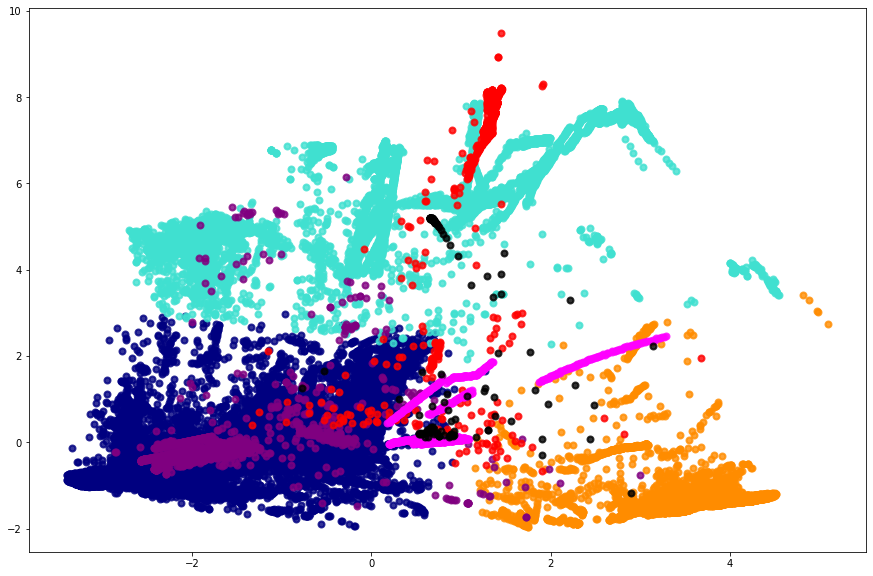

In [86]:
pca0 = PCA(n_components= 2)
train_df_trimmed_pca0 = pca0.fit_transform(train_df_trimmed)

plt.figure(figsize= (15, 10))

colors0 = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'red', 'magenta', 'black']
labels0 = [0,1,2,3,4,5,6,7]

for color, cat in zip(colors0, labels0):
    plt.scatter(train_df_trimmed_pca0[train_df.kmeans_y == cat, 0], train_df_trimmed_pca0[train_df.kmeans_y == cat, 1],
               color= color, alpha= .8, lw= 2, label= cat)

In [95]:
# Compute a simple cross tabulation of kmeans_y , and label 2
pd.crosstab(test_df.kmeans_y, test_df.lab2)

lab2,0,1
kmeans_y,,
0,5243,9471
1,4556,74
2,2469,30
4,539,77
5,4,15
6,21,41
7,1,3


# Ensembling strategy

#### 1.	For clusters that have an aggregate size of fewer than 200 samples, we consider them outliers and assign them the attack label.

#### 2.	For clusters with more than 95% of samples belonging to a single class, (either attack or benign) we assign the dominant label to the entire cluster.

#### 3.	For each of the remaining clusters, we train a separate **random forest** classifier

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Random Forest Classifier
## Cluster 0 (Strategy 3)

In [106]:
train_y0 = train_df[train_df.kmeans_y==0]
test_y0 = test_df[test_df.kmeans_y==0]
RF = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['lab2', 'lab5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['lab2'])
pred_y0 = RF.predict(test_y0.drop(['lab2', 'lab5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print("cluster {} score is {}, {}".format(0, accuracy_score(pred_y0, test_y0['lab2']), accuracy_score(pred_y0, test_y0['lab2'], normalize=False)))

print(confusion_matrix(test_y0['lab2'], pred_y0))

cluster 0 score is 0.7522767432377327, 11069
[[1747 3496]
 [ 149 9322]]


# Dominant Label Zero
## Cluster 1 (Strategy 2)

In [108]:
print(confusion_matrix(test_df[test_df.kmeans_y == 1]['lab2'], np.zeros(len(test_df[test_df.kmeans_y == 1]))))

[[4556    0]
 [  74    0]]


# Dominant Label Zero
## Cluster 2 (Strategy 2)

In [110]:
print(confusion_matrix(test_df[test_df.kmeans_y == 2]['lab2'], np.zeros(len(test_df[test_df.kmeans_y == 2]))))

[[2469    0]
 [  30    0]]


## Cluster 3 Empty Cluster

# Random Forest Classifier
## Cluster 4 (Strategy 3)

In [109]:
train_y0 = train_df[train_df.kmeans_y==4]
test_y0 = test_df[test_df.kmeans_y==4]
RF = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['lab2', 'lab5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['lab2'])
pred_y0 = RF.predict(test_y0.drop(['lab2', 'lab5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print("cluster {} score is {}, {}".format(0, accuracy_score(pred_y0, test_y0['lab2']), accuracy_score(pred_y0, test_y0['lab2'], normalize=False)))

print(confusion_matrix(test_y0['lab2'], pred_y0))

cluster 0 score is 0.9237012987012987, 569
[[503  36]
 [ 11  66]]


# outlier --> Attack 
## Cluster 5 (Strategy 1)

In [113]:
print(confusion_matrix(test_df[test_df.kmeans_y == 5]['lab2'], np.ones(len(test_df[test_df.kmeans_y == 5]))))

[[ 0  4]
 [ 0 15]]


# outlier --> Attack 
## Cluster 6 (Strategy 1)

In [114]:
print(confusion_matrix(test_df[test_df.kmeans_y == 6]['lab2'], np.ones(len(test_df[test_df.kmeans_y == 6]))))

[[ 0 21]
 [ 0 41]]


# Dominant Label Zero
## Cluster 7 (Strategy 2)

In [116]:
print(confusion_matrix(test_df[test_df.kmeans_y == 7]['lab2'], np.zeros(len(test_df[test_df.kmeans_y == 7]))))

[[1 0]
 [3 0]]


### Combined Results: k-means + Random Forest Classifier ensembling with AR feature selection

In [118]:
# Combine Results
num_samples = 22544
f_pos = 3496 + 36 + 4 + 21
f_neg = 149 + 74 + 30 + 11 + 3

print('True Positive %: {}'.format(1-(f_pos / num_samples)))
print('True Negative %: {}'.format(1- (f_neg / num_samples)))

True Positive %: 0.8422196593328601
True Negative %: 0.9881564939673527
